In [13]:
from hexalattice.hexalattice import create_hex_grid
import numpy as np
import meshio
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm
import os
from collections import deque
from numba import jit

output_folder = "simulation_results"
os.makedirs(output_folder, exist_ok=True)

# Parameters for the hexagonal grid
nx, ny = 25, 40  # Number of hexagons in the x and y directions
dx = 1           # Distance between centers of hexagons

# Create hexagonal grid
hex_centers, hex_grid = create_hex_grid(nx=nx, ny=ny, do_plot=False, min_diam=dx)

def get_hex_vertices(center):
    # Get vertices of hexagon with given center
    radius = 2/np.sqrt(3)*dx/2
    angles = np.linspace(0, 2 * np.pi, 7)[:-1]  # 6 vertices
    vertices = np.column_stack((center[0] + radius * np.cos(angles + np.pi/2),
                                center[1] + radius * np.sin(angles + np.pi/2)))
    return vertices

# Collect all vertices in the grid
hex_vertices_list = []
for center in hex_centers:
    hex_vertices_list.append(get_hex_vertices(center))
hex_vertices_array = np.vstack(hex_vertices_list)

# Ensure unique vertices and reshape cells
unique_vertices, indices = np.unique(hex_vertices_array.round(decimals=6), axis=0, return_inverse=True)
hex_cells = np.reshape(indices, (-1, 6))

# Define unique edges
unique_edges = []
for hexagon in hex_cells:
    for i in range(len(hexagon)):
        node1 = hexagon[i]
        node2 = hexagon[(i + 1) % len(hexagon)]  
        edge = tuple(sorted((node1, node2)))  
        if edge not in unique_edges:
            unique_edges.append(edge)

# Identify boundary nodes and edges
point_ids = np.arange(len(unique_vertices))
boundary_id = np.zeros(len(unique_vertices))

boundary_l, boundary_r, boundary_t, boundary_b = [], [], [], []
for i in point_ids:
    idx = np.where(hex_cells == i)
    if (1 in idx[1] and 5 not in idx[1]) or (2 in idx[1] and 4 not in idx[1]):
        boundary_l.append(i)
    if (5 in idx[1] and 1 not in idx[1]) or (4 in idx[1] and 2 not in idx[1]):
        boundary_r.append(i)
    if (0 in idx[1] and 2 not in idx[1] and 4 not in idx[1]) or (1 in idx[1] and 3 not in idx[1] and 5 in idx[1]):
        boundary_t.append(i)
    if (3 in idx[1] and 1 not in idx[1] and 5 not in idx[1]) or (4 in idx[1] and 0 not in idx[1] and 2 in idx[1]):
        boundary_b.append(i)

boundary_id[np.unique(boundary_t)] = 1
boundary_id[np.unique(boundary_b)] = 2
boundary_id[np.unique(boundary_l)] = 3
boundary_id[np.unique(boundary_r)] = 4

# Identify edges on/connected to boundary
boundary_status = np.zeros(len(unique_edges))
for e in range(len(unique_edges)):
    node1, node2 = unique_edges[e]
    if boundary_id[node1] > 0 and boundary_id[node2] > 0:
        boundary_status[e] = 2
    elif (boundary_id[node1] > 0 and boundary_id[node2] == 0) or (boundary_id[node1] == 0 and boundary_id[node2] > 0):
        boundary_status[e] = 1

# Export to VTK
points = unique_vertices
mesh = meshio.Mesh(points, [("line", unique_edges)], point_data={'Boundary_nodes': boundary_id}, cell_data={'Boundary_edges': [boundary_status]})

output_file_edge = os.path.join(output_folder, "hexagonal_mesh_EDGE.vtk")
meshio.write(output_file_edge, mesh)

# Agent-related constants
At = 10.0         # Fibrotic threshold for cross-sectional area
A0 = 1            # Initial cross-sectional area
epsilon_s = 1.0   # Target strain
beta = 3.0        # Steepness for stiffness Hill function
gamma = 1.0       # Steepness for strain Hill function
w1, w2 = 1, 1.0 # Weights for strain and stiffness contributions
c = 0.5*w1 + w2*(A0 / At) ** beta / ((A0 / At) ** beta + 1)
r = 1.0             # Memory factor
P = 0.2           # Scaling constant for spring constant update
p1 = 0.01         # Probability of new Agent appearing
D_0 = 0.3          # Initial agent density
Dmax = 3




# Initialize Agent Parameters
num_springs = len(unique_edges)
epsilon = np.ones(num_springs)   # Initial strain for each spring
a = np.zeros(num_springs)         # Initial activation level for each spring
D = np.full(num_springs, 0.3)     # Initial agent density for each spring


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

In [14]:
def identify_regions(spring_constants, k_fibrosis, k_normal):
    """
    Identify which springs are inside the stiffened region and which are on the edge.
    Returns two boolean arrays: inside_region, edge_region.
    """
    inside_region = np.zeros(len(spring_constants), dtype=bool)
    edge_region = np.zeros(len(spring_constants), dtype=bool)
    
    # Iterate over each spring
    for spring_index, k_value in enumerate(spring_constants):
        # Identify neighbors of the current spring
        nodes = edges[spring_index]
        connected = np.where((nodes[0] == edges[:, 0]) | 
                             (nodes[0] == edges[:, 1]) | 
                             (nodes[1] == edges[:, 0]) | 
                             (nodes[1] == edges[:, 1]))[0]
        
        neighbor_stiffness = spring_constants[connected]
        
        # If all neighbors are stiff, the spring is inside the stiffened region
        if np.all(neighbor_stiffness >= 30):
            inside_region[spring_index] = True
        # If some neighbors are stiff and some are normal, it's on the edge
        elif np.any(neighbor_stiffness >= 30) and np.any(neighbor_stiffness == 30):
            edge_region[spring_index] = True
    
    return inside_region, edge_region

def compute_strain_and_stress(points, edges, l0, spring_constants):
    """
    Compute strain and stress for each spring based on the current positions.
    Returns two arrays: strain and stress.
    """
    strain = np.zeros(len(edges))
    stress = np.zeros(len(edges))

    for i, edge in enumerate(edges):
        node1, node2 = edge
        p1, p2 = points[node1], points[node2]

        # Calculate current length of the spring
        current_length = np.linalg.norm(p2 - p1)
        
        # Calculate strain and stress
        strain[i] = (current_length - l0) / l0
        stress[i] = spring_constants[i] * strain[i]

    return strain, stress


def compute_spring_force(p1, p2, l0, k):
    current_length = np.linalg.norm(p2 - p1)
    displacement = current_length - l0
    force_magnitude = k * displacement  # Force magnitude based on spring constant

    direction = (p2 - p1) / current_length
    force = force_magnitude * direction
    return force

# Calculate forces on each node from all connected springs
@jit(nopython=True)
def compute_total_forces_numba(forces_on_nodes, points, edges, l0, spring_constants):
    forces_on_nodes[:] = 0  # Reset forces to zero at each iteration
    for i in range(len(edges)):
        node1, node2 = edges[i]
        p1, p2 = points[node1], points[node2]

        # Compute force directly without additional function call
        current_length = np.linalg.norm(p2 - p1)
        displacement = current_length - l0
        force_magnitude = spring_constants[i] * displacement
        direction = (p2 - p1) / current_length

        force = force_magnitude * direction

        forces_on_nodes[node1] += force
        forces_on_nodes[node2] -= force  # Opposite force on node2

@jit(nopython=True)
def move_nodes_numba(points, forces_on_nodes, mu, free_nodes):
    for i in free_nodes[0]:  # Iterate only over free nodes
        points[i] += mu * forces_on_nodes[i]

@jit(nopython=True)
def compute_total_energy_numba(points, edges, l0, spring_constants):
    total_energy = 0.0
    for i in range(len(edges)):
        node1, node2 = edges[i]
        p1, p2 = points[node1], points[node2]

        # Calculate energy directly
        current_length = np.linalg.norm(p2 - p1)
        displacement = current_length - l0
        energy = 0.5 * spring_constants[i] * displacement ** 2
        total_energy += energy
    return total_energy

# Remove specified edges and corresponding spring constants
def remove_edge(edges, points, spring_constants, removed_id):
    point_ids = np.arange(len(points))
    
    # Step 1: Remove edges that should be removed
    for i in removed_id:
        edges = np.delete(edges, i, axis=0)
        spring_constants = np.delete(spring_constants, i, axis=0)

    # Step 2: Remove edges that have become disconnected after Step 1
    for i in point_ids:
        idx = np.where(edges == i)
        n_of_edges = len(idx[0])

        if n_of_edges==1:
            edges = np.delete(edges, idx[0], axis=0)
            spring_constants = np.delete(spring_constants, idx[0], axis=0)

    return edges, spring_constants

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Functions for agent-specific updates
# Stiffness-based activation
# Parameters for softening phase


# Functions for agent-specific updates

# Stiffness-based activation
def calc_aK(A, At, beta):
    return (A / At) ** beta / ((A / At) ** beta + 1)

# Strain-based activation
def calc_aepsilon(epsilon, epsilon_s, gamma):
    return (epsilon / epsilon_s) ** gamma / ((epsilon / epsilon_s) ** gamma + 1)

# Update the activation with memory effect
def update_activation(a, a_epsilon, a_K, w1, w2, c, r):
    return a * (1 - r) + r * (w1 * a_epsilon + w2 * a_K - c)

# Update agent density
def update_agent_density(D, a, p1, n, s, D_0, Dmax, w2):
    X = Dmax / D_0
    p2 = p1 * n / (s * D_0)
    p3 = (p2 * (1 - (1 / X))) / (w2 - 0.5)
    return D + (p1 * n / s) + (p3 * a - p2) * D

def calculate_spring_constants(areas, young_modulus, l0):
    """Calculate spring constants based on area and Young's modulus."""
    return (young_modulus * areas) #/ l0


def update_modulus_and_area(E, A, spring_constants, a, D, P_modulus, P_area, soften_triggered, soften_duration, recovery_rate, E_baseline, one_time_triggered):
    """
    Update Young's modulus (E) with individual softening and recovery behavior that triggers only once,
    and update area (A) directly based on agent activation.
    """
    new_E = E.copy()
    new_A = A.copy()
    
    for i in range(len(a)):
        # Check if stiffness exceeds threshold to trigger softening for E (only if not triggered before)
        if spring_constants[i] > 5 and not one_time_triggered[i]:
            soften_triggered[i] = True
            one_time_triggered[i] = True  # Mark as triggered once permanently

        # Update area A directly based on agent activation
        new_A[i] += P_area * a[i] * D[i]  # Adjust A continuously based on agent effect

        # Update modulus E with softening and recovery behavior
        if soften_triggered[i]:
            if soften_duration[i] > 0:
                # Apply softening phase
                new_E[i] = max(new_E[i] - P_modulus * a[i] * D[i], 0.1)  # Ensure E doesn't drop below 0.1
                soften_duration[i] -= 1  # Decrease remaining softening time
            else:
                # Recovery phase: incrementally restore E towards E_baseline
                new_E[i] = min(new_E[i] + recovery_rate * (E_baseline - new_E[i]), E_baseline)
                if new_E[i] >= E_baseline:  # Once recovered to baseline, reset softening trigger
                    soften_triggered[i] = False

    return new_A , new_E

# Update spring constants with a softening phase followed by normal behavior
def update_spring_constant(spring_constants, a, D, P, phase):
    new_spring_constants = spring_constants.copy()
    
    for i in range(len(a)):
        if phase < softening_duration:
            # Apply softening during the initial phase
            new_spring_constants[i] += P * a[i] * D[i]
            #softened_stiffness = spring_constants[i] * (1 - softening_factor * a[i] * D[i])
            #new_spring_constants[i] = max(softened_stiffness, 0)  # Prevent negative stiffness
        else:
            # Normal behavior after softening phase: no further modification
            new_spring_constants[i] += P * a[i] * D[i]
        
        # Optional: Update history with new stiffness value
        spring_history[i].append(new_spring_constants[i])
    
    return new_spring_constants

def plot_energy(energy):

    plt.plot(energy)

    plt.xlabel("Number of iterations")
    plt.ylabel("Total energy")

    plt.show()
    plt.clf()

In [15]:
def simulate(points, edges, l0, spring_constants, mu, T, tolerance, max_iterations, free_nodes, plot_bar=True, print_results=False, energy_plot=True):
    if plot_bar:
        progress_bar = tqdm(total=max_iterations, desc="Simulation Progress")

    iteration = 0
    previous_energy = compute_total_energy_numba(points, edges, l0, spring_constants)
    delta_energy = 10
    stagnation_counter = 0
    stagnation = False

    # Set up tracking for energy
    energy = [] if energy_plot else None
    forces_on_nodes = np.zeros_like(points)  # Initialize forces array

    while iteration < max_iterations and not stagnation:
        # In-place force calculation
        compute_total_forces_numba(forces_on_nodes, points, edges, l0, spring_constants)

        temp_points = points.copy()
        # In-place node movement
        move_nodes_numba(temp_points, forces_on_nodes, mu, free_nodes)

        # In-place energy calculation
        new_energy = compute_total_energy_numba(temp_points, edges, l0, spring_constants)

        if energy_plot:
            energy.append(new_energy)

        delta_energy = new_energy - previous_energy
        relative_energy_change = abs(delta_energy) / abs(new_energy)
        stagnation_counter = stagnation_counter + 1 if relative_energy_change < tolerance else 0
        stagnation = stagnation_counter >= 20

        # Acceptance criteria
        if delta_energy < 0:
            previous_energy = new_energy
            points = temp_points
            mu *= 1.1
            P = 0
        else:
            P = np.exp(-delta_energy / T)
            if np.random.random() < P:
                previous_energy = new_energy
                points = temp_points
            else:
                mu *= 0.9  # Reject configuration

        T *= 0.99
        iteration += 1
        if plot_bar:
            progress_bar.update(1)

        if print_results and (iteration == 1 or iteration % 250 == 0):
            print(f"Iteration {iteration}, mu: {mu}, T: {T}, P = {P}")
            print(f"New energy: {new_energy}")
            print("Energy change:", delta_energy)
            print("Number of edges:", len(edges))

    if energy_plot:
        plot_energy(energy)

    return points, edges, spring_constants

Simulation Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

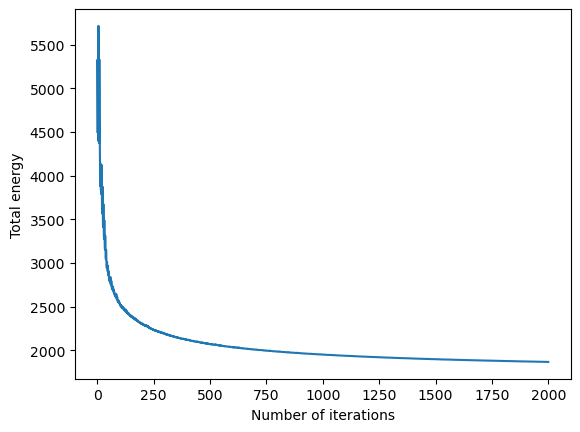

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

<Figure size 640x480 with 0 Axes>

In [16]:
# Load the mesh with edges
mesh_path = "simulation_results/hexagonal_mesh_EDGE.vtk"  # Specify the path to the mesh file
mesh_EDGE = meshio.read(mesh_path)  # Load edges from VTK file

# Extract the points (coordinates) and edges (line cells)
points = mesh_EDGE.points[:, :2]  # Use only x, y coordinates for 2D mesh
edges = mesh_EDGE.cells_dict['line']  # Get line elements representing edges

# Boundary identification
boundary_node_ids = mesh_EDGE.point_data['Boundary_nodes']
boundary_edge_ids = mesh_EDGE.cell_data['Boundary_edges'][0]

# Simulation parameters
k_normal = 1.0             # Normal spring constant for healthy springs
k_fibrosis = 100 * k_normal  # Increased stiffness for fibrotic springs
dx = 1.0                    # Initial distance factor (ensure you update this as needed)
l0 = 0.4 * (2 / np.sqrt(3) * dx / 2)  # Rest length for the springs
mu = 0.01                   # Initial step size for nodal movement
T = 1.0                     # Initial temperature for simulated annealing
alpha = 0.3                # Proportion of springs that will become fibrotic
max_iterations = 1200        # Maximum iterations for each convergence cycle
tolerance = 1e-7            # Tolerance for convergence based on relative energy change
walk_length = 200           # Length of the random walk for fibrosis spread
soften_rate = 1             # Softening rate for agents in specific regions
P_modulus = 0.0005

softening_factor = 0.002    # Factor to reduce stiffness during the softening phase

# Initialize a history tracking list for each spring (optional)
history_length = 10       # Number of past values to keep for each spring

# Set initial spring constants
E_initial = 1.0  # Set baseline Young's modulus value
young_modulus = np.full(len(edges), E_initial) 
spring_constants = np.full(len(edges), k_normal)  # All springs start with normal stiffness
spring_history = [deque([k], maxlen=history_length) for k in spring_constants]  # Stiffness history
# Free nodes (not on boundary)
free_nodes = np.where(boundary_node_ids == 0)

soften_triggered = np.zeros(len(spring_constants), dtype=bool)  # Track if softening has been triggered
soften_duration = np.full(len(spring_constants), 150)  # Duration of softening for each spring
recovery_rate = 0.003  # Rate at which E recovers after softening
E_baseline = 1.0  # Target baseline value for E

# Run the random walk for fibrosis initialization
healthy_ids = np.where((spring_constants == k_normal))[0]
while len(healthy_ids) / len(edges) > 1 - alpha:
    #feasible_ids = np.where(spring_constants == k_normal)[0]
    feasible_ids = np.where((spring_constants==k_normal)&(boundary_edge_ids == 1 ))[0]
    new_stiff = np.random.choice(feasible_ids)
    spring_constants[new_stiff] = k_fibrosis

    # Do random walk (spread fibrosis)
    for i in range(walk_length):
        nodes = edges[new_stiff]
        connected = np.where(
            (nodes[0] == edges[:, 0]) | (nodes[0] == edges[:, 1]) | (nodes[1] == edges[:, 0]) | (nodes[1] == edges[:, 1])
        )
        new_stiff = np.random.choice(connected[0])
        spring_constants[new_stiff] = k_fibrosis

    # Update
    healthy_ids = np.where((spring_constants == k_normal))[0]

# Pre-converge step
points = np.asarray(points, dtype=np.float64)
edges = np.asarray(edges, dtype=np.int32)
spring_constants = np.asarray(spring_constants, dtype=np.float64)

pre_convergence_iterations = 2000
final_positions, final_edges, final_spring_constants = simulate(
    points, edges, l0, spring_constants, mu, T, tolerance, pre_convergence_iterations, free_nodes
)

points = final_positions
edges = final_edges
spring_constants = final_spring_constants
A = spring_constants
strain, stress = compute_strain_and_stress(final_positions, edges, l0, spring_constants)
filename = os.path.join(output_folder, "hexagonal_mesh_final_result_EDGE_init.vtk")
meshio.write(
    filename,
    meshio.Mesh(
        final_positions,
        cells=[("line", final_edges)],
        cell_data={
            "Stiffness": [spring_constants],
            "Strain": [strain],
            "Stress": [stress]
        }
    )
)


In [17]:
# Simulation with agent
# Specify the output folder and filename
output_folder = "simulation_results"
filename = os.path.join(output_folder, "hexagonal_mesh_final_result_EDGE_init.vtk")

# Load the mesh from the initial file
mesh = meshio.read(filename)
points = mesh.points[:, :2]  # Extract x, y coordinates for 2D
edges = mesh.cells_dict["line"]  # Extract edges from the loaded mesh

# Extract any initial spring constants, if available; otherwise, initialize
try:
    spring_constants = mesh.cell_data["Stiffness"][0]
except KeyError:
    k_normal = 1.0  # Default spring constant
    spring_constants = np.full(len(edges), k_normal)



# Simulation with agent
print("Agent-based simulation")
agent_update_interval = 1500
agent_total_iterations = 600  # Total iterations in agent-driven phase
activation_history = []
agent_density_history = []
stiffness_history = []
epsilon_history = []
stress_history = []
E_history = []

one_time_triggered = np.zeros(len(spring_constants), dtype=bool)

for phase in range(0, agent_total_iterations):
    
    # Update the agent density and activation here based on the new state of the system
    #epsilon = (A0*epsilon_s)/spring_constants # + epsilon (I'm not sure about this)
    epsilon, stress = compute_strain_and_stress(points, edges, l0, spring_constants)

    a_K = calc_aK(spring_constants, At, beta)
    a_epsilon = calc_aepsilon(epsilon, epsilon_s, gamma)
    a = update_activation(a, a_epsilon, a_K, w1, w2, c, r)

    #inside_region, edge_region = identify_regions(spring_constants, k_fibrosis, k_normal)
    A, young_modulus = update_modulus_and_area(
        young_modulus, A, spring_constants, a, D, P_modulus, P, soften_triggered, soften_duration, recovery_rate, E_baseline,one_time_triggered
    )

    #spring_constants = update_spring_constant(spring_constants, a, D, P, phase)
    spring_constants = calculate_spring_constants(A, young_modulus, l0)

    D = update_agent_density(D, a, p1, len(points), len(edges), D_0, Dmax, w2)
    D = np.clip(D, D_0, Dmax)  # Bound the agent density

    # Track the mean activation and agent density for plotting
    activation_history.append(np.mean(a))
    agent_density_history.append(np.mean(D))
    stiffness_history.append(np.mean(spring_constants))
    epsilon_history.append(np.mean(epsilon))
    stress_history.append(np.mean(stress))
    E_history.append(np.mean(young_modulus))
    
    # Run the simulation for the interval period
    points = np.asarray(points, dtype=np.float64)
    edges = np.asarray(edges, dtype=np.int32)
    spring_constants = np.asarray(spring_constants, dtype=np.float64)
    final_positions, edges, spring_constants = simulate(
        points, edges, l0, spring_constants, mu, T, tolerance, agent_update_interval, free_nodes, False, False, False)
    
    strain, stress = compute_strain_and_stress(final_positions, edges, l0, spring_constants)
    # Update points based on new positions
    points = final_positions

    # Save output every second phase
    if phase % 2 == 0:
        print(f"Phase: {phase}, D max: {np.max(D)}, Mean Stiffness: {np.mean(spring_constants)}")
        filename = os.path.join(output_folder, f"hexagonal_mesh_final_result_EDGE_agent_{str(phase).zfill(4)}.vtk")
        meshio.write(
            filename,
            meshio.Mesh(
                final_positions,
                cells=[("line", final_edges)],
                cell_data={
                    "Stiffness": [spring_constants],
                    "Strain": [strain],
                    "Stress": [stress],
                    "E": [young_modulus],
                    "A": [A]
                }
            )
        )

# Final mesh output
filename = os.path.join(output_folder, "hexagonal_mesh_final_result_EDGE.vtk")
meshio.write(
    filename,
    meshio.Mesh(
        final_positions,
        cells=[("line", final_edges)],
        cell_data={
            "Stiffness": [spring_constants],
            "Strain": [strain],
            "Stress": [stress]
        }
    )
)


Agent-based simulation
Phase: 0, D max: 0.3145640672295088, Mean Stiffness: 30.98025649253898


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 2, D max: 0.3448177237110904, Mean Stiffness: 31.016939906542085


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 4, D max: 0.37663672150888017, Mean Stiffness: 31.05540318841664


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 6, D max: 0.4101007764114305, Mean Stiffness: 31.095642448565854


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 8, D max: 0.4452929441713759, Mean Stiffness: 31.13770008267358


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 10, D max: 0.4823000971806862, Mean Stiffness: 31.181606593290557


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 12, D max: 0.5212132315162212, Mean Stiffness: 31.22740252340561


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 14, D max: 0.5621276303230854, Mean Stiffness: 31.2751334753974


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 16, D max: 0.6051431584813451, Mean Stiffness: 31.324845390320032


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 18, D max: 0.6503644195324632, Mean Stiffness: 31.376584692491264


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 20, D max: 0.6979010332528206, Mean Stiffness: 31.43040283847859


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 22, D max: 0.7478678662771421, Mean Stiffness: 31.486349618556872


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 24, D max: 0.8003857941170834, Mean Stiffness: 31.544468977423797


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 26, D max: 0.8555805578352358, Mean Stiffness: 31.60482623534815


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 28, D max: 0.9135840014259854, Mean Stiffness: 31.66746308358016


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 30, D max: 0.9745344287628446, Mean Stiffness: 31.73244048092758


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 32, D max: 1.0385769510029437, Mean Stiffness: 31.79981129083896


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 34, D max: 1.1058623420655647, Mean Stiffness: 31.86962359939983


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 36, D max: 1.1765491794596261, Mean Stiffness: 31.941948478490364


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 38, D max: 1.250803911115342, Mean Stiffness: 32.01683985336387


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 40, D max: 1.3288002658543734, Mean Stiffness: 32.094365328526685


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 42, D max: 1.410719124176266, Mean Stiffness: 32.174583040753944


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 44, D max: 1.4967508880712868, Mean Stiffness: 32.257561084083264


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 46, D max: 1.5870946182110555, Mean Stiffness: 32.34335987548139


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 48, D max: 1.6819581797255778, Mean Stiffness: 32.43205207540429


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 50, D max: 1.7815585382179258, Mean Stiffness: 32.52370008409216


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 52, D max: 1.8861239077243814, Mean Stiffness: 32.618375648264994


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 54, D max: 1.9958904791026186, Mean Stiffness: 32.71614887774605


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 56, D max: 2.1111074955302986, Mean Stiffness: 32.817093490398285


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 58, D max: 2.2320336658631716, Mean Stiffness: 32.92128971106472


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 60, D max: 2.358940050803359, Mean Stiffness: 33.028796180994114


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 62, D max: 2.4921096513457393, Mean Stiffness: 33.13970077312309


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 64, D max: 2.6318380814798195, Mean Stiffness: 33.254064161184374


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 66, D max: 2.7784339011070527, Mean Stiffness: 33.37196995984142


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 68, D max: 2.9322199673020335, Mean Stiffness: 33.493487221610174


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 70, D max: 3.0, Mean Stiffness: 33.61869677477828


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 72, D max: 3.0, Mean Stiffness: 33.74764292173372


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 74, D max: 3.0, Mean Stiffness: 33.88038294713647


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 76, D max: 3.0, Mean Stiffness: 34.01695775465772


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 78, D max: 3.0, Mean Stiffness: 34.15717991168035


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 80, D max: 3.0, Mean Stiffness: 34.300042918168785


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 82, D max: 3.0, Mean Stiffness: 34.44534714247024


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 84, D max: 3.0, Mean Stiffness: 34.59295986506174


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 86, D max: 3.0, Mean Stiffness: 34.7427418573263


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 88, D max: 3.0, Mean Stiffness: 34.89446056042458


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 90, D max: 3.0, Mean Stiffness: 35.047930515949915


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 92, D max: 3.0, Mean Stiffness: 35.20293363965869


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 94, D max: 3.0, Mean Stiffness: 35.35923884150551


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 96, D max: 3.0, Mean Stiffness: 35.5166708571772


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 98, D max: 3.0, Mean Stiffness: 35.67511623537596


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 100, D max: 3.0, Mean Stiffness: 35.83452532780541


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 102, D max: 3.0, Mean Stiffness: 35.99482733805602


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 104, D max: 3.0, Mean Stiffness: 36.15595927004681


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 106, D max: 3.0, Mean Stiffness: 36.31785530557596


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 108, D max: 3.0, Mean Stiffness: 36.48044916396932


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 110, D max: 3.0, Mean Stiffness: 36.643661895969686


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 112, D max: 3.0, Mean Stiffness: 36.80743256542171


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 114, D max: 3.0, Mean Stiffness: 36.97169586762418


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 116, D max: 3.0, Mean Stiffness: 37.136458021294345


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 118, D max: 3.0, Mean Stiffness: 37.30168874219954


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 120, D max: 3.0, Mean Stiffness: 37.467382186643114


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 122, D max: 3.0, Mean Stiffness: 37.633540090954284


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 124, D max: 3.0, Mean Stiffness: 37.80014445959406


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 126, D max: 3.0, Mean Stiffness: 37.96716531105796


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 128, D max: 3.0, Mean Stiffness: 38.134526142236396


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 130, D max: 3.0, Mean Stiffness: 38.30222376714656


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 132, D max: 3.0, Mean Stiffness: 38.470209392646716


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 134, D max: 3.0, Mean Stiffness: 38.63840657888962


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 136, D max: 3.0, Mean Stiffness: 38.80681947160129


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 138, D max: 3.0, Mean Stiffness: 38.97542717583729


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 140, D max: 3.0, Mean Stiffness: 39.144215945627046


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 142, D max: 3.0, Mean Stiffness: 39.31317405792205


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 144, D max: 3.0, Mean Stiffness: 39.48221192503689


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 146, D max: 3.0, Mean Stiffness: 39.65131285760545


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 148, D max: 3.0, Mean Stiffness: 39.8204492085937


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 150, D max: 3.0, Mean Stiffness: 40.051999088013304


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 152, D max: 3.0, Mean Stiffness: 40.34746985538614


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 154, D max: 3.0, Mean Stiffness: 40.64497664545644


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 156, D max: 3.0, Mean Stiffness: 40.94445753155096


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 158, D max: 3.0, Mean Stiffness: 41.245914364287735


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 160, D max: 3.0, Mean Stiffness: 41.54938598097769


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 162, D max: 3.0, Mean Stiffness: 41.854834744310985


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 164, D max: 3.0, Mean Stiffness: 42.16233965730822


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 166, D max: 3.0, Mean Stiffness: 42.47191666573733


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 168, D max: 3.0, Mean Stiffness: 42.783547490328445


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 170, D max: 3.0, Mean Stiffness: 43.09728917143713


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 172, D max: 3.0, Mean Stiffness: 43.413128185188405


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 174, D max: 3.0, Mean Stiffness: 43.73109402594732


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 176, D max: 3.0, Mean Stiffness: 44.051234570922446


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 178, D max: 3.0, Mean Stiffness: 44.373503907426674


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 180, D max: 3.0, Mean Stiffness: 44.697958239094184


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 182, D max: 3.0, Mean Stiffness: 45.02467498710613


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 184, D max: 3.0, Mean Stiffness: 45.35368483998075


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 186, D max: 3.0, Mean Stiffness: 45.6849990137656


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 188, D max: 3.0, Mean Stiffness: 46.01872129683946


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 190, D max: 3.0, Mean Stiffness: 46.3548258157693


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 192, D max: 3.0, Mean Stiffness: 46.693353973159745


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 194, D max: 3.0, Mean Stiffness: 47.03433479358724


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 196, D max: 3.0, Mean Stiffness: 47.377784435739365


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 198, D max: 3.0, Mean Stiffness: 47.72376339030836


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 200, D max: 3.0, Mean Stiffness: 48.07223009330779


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 202, D max: 3.0, Mean Stiffness: 48.42326809026466


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 204, D max: 3.0, Mean Stiffness: 48.77692279069399


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 206, D max: 3.0, Mean Stiffness: 49.133200945135066


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 208, D max: 3.0, Mean Stiffness: 49.492116779636916


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 210, D max: 3.0, Mean Stiffness: 49.853790416418796


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 212, D max: 3.0, Mean Stiffness: 50.218240973981636


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 214, D max: 3.0, Mean Stiffness: 50.58554506827179


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 216, D max: 3.0, Mean Stiffness: 50.95563787838026


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 218, D max: 3.0, Mean Stiffness: 51.32863346204397


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 220, D max: 3.0, Mean Stiffness: 51.70455072091433


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 222, D max: 3.0, Mean Stiffness: 52.08350925837222


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 224, D max: 3.0, Mean Stiffness: 52.46559523465577


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 226, D max: 3.0, Mean Stiffness: 52.850826919954386


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 228, D max: 3.0, Mean Stiffness: 53.23920770059252


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 230, D max: 3.0, Mean Stiffness: 53.63087873033598


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 232, D max: 3.0, Mean Stiffness: 54.02584024380375


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 234, D max: 3.0, Mean Stiffness: 54.4242117880786


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 236, D max: 3.0, Mean Stiffness: 54.82614648362627


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 238, D max: 3.0, Mean Stiffness: 55.23172976175278


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 240, D max: 3.0, Mean Stiffness: 55.641125631620994


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 242, D max: 3.0, Mean Stiffness: 56.054424971238184


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 244, D max: 3.0, Mean Stiffness: 56.47172259385754


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 246, D max: 3.0, Mean Stiffness: 56.893170537142765


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 248, D max: 3.0, Mean Stiffness: 57.31874221437399


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 250, D max: 3.0, Mean Stiffness: 57.748570093826785


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 252, D max: 3.0, Mean Stiffness: 58.18270648778642


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 254, D max: 3.0, Mean Stiffness: 58.62127037935486


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 256, D max: 3.0, Mean Stiffness: 59.06437394572315


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 258, D max: 3.0, Mean Stiffness: 59.51206212202616


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 260, D max: 3.0, Mean Stiffness: 59.96470890590685


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 262, D max: 3.0, Mean Stiffness: 60.42242091343575


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 264, D max: 3.0, Mean Stiffness: 60.885464954081385


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 266, D max: 3.0, Mean Stiffness: 61.35381057600919


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 268, D max: 3.0, Mean Stiffness: 61.82745493161931


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 270, D max: 3.0, Mean Stiffness: 62.30690761024886


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 272, D max: 3.0, Mean Stiffness: 62.79211729108529


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 274, D max: 3.0, Mean Stiffness: 63.28323517767119


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 276, D max: 3.0, Mean Stiffness: 63.78028933303937


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 278, D max: 3.0, Mean Stiffness: 64.28334851137734


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 280, D max: 3.0, Mean Stiffness: 64.79251662516745


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 282, D max: 3.0, Mean Stiffness: 65.30805188349102


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 284, D max: 3.0, Mean Stiffness: 65.8303558350983


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 286, D max: 3.0, Mean Stiffness: 66.35947888430256


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 288, D max: 3.0, Mean Stiffness: 66.89613065662476


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 290, D max: 3.0, Mean Stiffness: 67.44021798725404


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 292, D max: 3.0, Mean Stiffness: 67.99158852186888


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 294, D max: 3.0, Mean Stiffness: 68.5505211910992


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 296, D max: 3.0, Mean Stiffness: 69.11720148651935


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 298, D max: 3.0, Mean Stiffness: 69.69197798023522


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 300, D max: 3.0, Mean Stiffness: 70.27457163077138


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 302, D max: 3.0, Mean Stiffness: 70.86524983764019


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 304, D max: 3.0, Mean Stiffness: 71.46389290124233


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 306, D max: 3.0, Mean Stiffness: 72.07092990903652


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 308, D max: 3.0, Mean Stiffness: 72.68647282661962


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 310, D max: 3.0, Mean Stiffness: 73.31079917509658


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 312, D max: 3.0, Mean Stiffness: 73.94422079795254


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 314, D max: 3.0, Mean Stiffness: 74.58687393560211


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 316, D max: 3.0, Mean Stiffness: 75.23868344113093


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 318, D max: 3.0, Mean Stiffness: 75.90024105389796


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 320, D max: 3.0, Mean Stiffness: 76.57149373812663


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 322, D max: 3.0, Mean Stiffness: 77.25290023371974


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 324, D max: 3.0, Mean Stiffness: 77.9446285400902


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 326, D max: 3.0, Mean Stiffness: 78.6463908357109


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 328, D max: 3.0, Mean Stiffness: 79.35843342934652


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 330, D max: 3.0, Mean Stiffness: 80.08077350096902


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 332, D max: 3.0, Mean Stiffness: 80.81343089911027


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 334, D max: 3.0, Mean Stiffness: 81.55700147810795


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 336, D max: 3.0, Mean Stiffness: 82.31095412657903


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 338, D max: 3.0, Mean Stiffness: 83.07544941189924


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 340, D max: 3.0, Mean Stiffness: 83.85044351411658


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 342, D max: 3.0, Mean Stiffness: 84.63635075637383


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 344, D max: 3.0, Mean Stiffness: 85.43295151058935


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 346, D max: 3.0, Mean Stiffness: 86.24038487322849


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 348, D max: 3.0, Mean Stiffness: 87.05838544717486


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 350, D max: 3.0, Mean Stiffness: 87.88667876576643


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 352, D max: 3.0, Mean Stiffness: 88.7250117286026


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 354, D max: 3.0, Mean Stiffness: 89.57375696869555


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 356, D max: 3.0, Mean Stiffness: 90.43252953557925


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 358, D max: 3.0, Mean Stiffness: 91.30138868681134


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 360, D max: 3.0, Mean Stiffness: 92.17937987637886


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 362, D max: 3.0, Mean Stiffness: 93.0663262209293


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 364, D max: 3.0, Mean Stiffness: 93.96237071908183


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 366, D max: 3.0, Mean Stiffness: 94.86709295482797


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 368, D max: 3.0, Mean Stiffness: 95.78048603971827


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 370, D max: 3.0, Mean Stiffness: 96.70222963518792


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 372, D max: 3.0, Mean Stiffness: 97.63244262581115


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 374, D max: 3.0, Mean Stiffness: 98.57157784120263


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 376, D max: 3.0, Mean Stiffness: 99.51917167656103


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 378, D max: 3.0, Mean Stiffness: 100.47433853269158


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 380, D max: 3.0, Mean Stiffness: 101.43670365166314


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 382, D max: 3.0, Mean Stiffness: 102.40610999802439


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 384, D max: 3.0, Mean Stiffness: 103.38210613210686


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 386, D max: 3.0, Mean Stiffness: 104.36439317971801


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 388, D max: 3.0, Mean Stiffness: 105.3530509787912


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 390, D max: 3.0, Mean Stiffness: 106.34781599426474


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 392, D max: 3.0, Mean Stiffness: 107.34864609326044


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 394, D max: 3.0, Mean Stiffness: 108.35544777664718


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 396, D max: 3.0, Mean Stiffness: 109.36789890502317


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 398, D max: 3.0, Mean Stiffness: 110.38559521603364


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 400, D max: 3.0, Mean Stiffness: 111.4089628467878


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 402, D max: 3.0, Mean Stiffness: 112.43756983692428


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 404, D max: 3.0, Mean Stiffness: 113.47148097777806


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 406, D max: 3.0, Mean Stiffness: 114.51040644669072


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 408, D max: 3.0, Mean Stiffness: 115.55425156023335


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 410, D max: 3.0, Mean Stiffness: 116.60296449593379


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 412, D max: 3.0, Mean Stiffness: 117.65645338307648


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 414, D max: 3.0, Mean Stiffness: 118.71455913713922


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 416, D max: 3.0, Mean Stiffness: 119.77728253073624


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 418, D max: 3.0, Mean Stiffness: 120.8443963110647


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 420, D max: 3.0, Mean Stiffness: 121.91573608168362


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 422, D max: 3.0, Mean Stiffness: 122.99149108846267


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 424, D max: 3.0, Mean Stiffness: 124.07160014344399


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 426, D max: 3.0, Mean Stiffness: 125.15596488590121


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 428, D max: 3.0, Mean Stiffness: 126.24478776909163


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 430, D max: 3.0, Mean Stiffness: 127.338056564218


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 432, D max: 3.0, Mean Stiffness: 128.43568914413652


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 434, D max: 3.0, Mean Stiffness: 129.53769116342164


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 436, D max: 3.0, Mean Stiffness: 130.64395388500282


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 438, D max: 3.0, Mean Stiffness: 131.7544967843852


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 440, D max: 3.0, Mean Stiffness: 132.86908457186007


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 442, D max: 3.0, Mean Stiffness: 133.9874299982803


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 444, D max: 3.0, Mean Stiffness: 135.10973685135025


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 446, D max: 3.0, Mean Stiffness: 136.2357911506501


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 448, D max: 3.0, Mean Stiffness: 137.36555925671217


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 450, D max: 3.0, Mean Stiffness: 138.49913772301085


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 452, D max: 3.0, Mean Stiffness: 139.63643995971503


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 454, D max: 3.0, Mean Stiffness: 140.77743472295984


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 456, D max: 3.0, Mean Stiffness: 141.92179401129732


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 458, D max: 3.0, Mean Stiffness: 143.069657882125


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 460, D max: 3.0, Mean Stiffness: 144.22080187469103


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 462, D max: 3.0, Mean Stiffness: 145.37545799873425


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 464, D max: 3.0, Mean Stiffness: 146.5335578039827


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 466, D max: 3.0, Mean Stiffness: 147.6949264286784


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 468, D max: 3.0, Mean Stiffness: 148.85951980837902


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 470, D max: 3.0, Mean Stiffness: 150.02714659871762


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 472, D max: 3.0, Mean Stiffness: 151.19778733921362


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 474, D max: 3.0, Mean Stiffness: 152.37163300276987


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 476, D max: 3.0, Mean Stiffness: 153.5483926405123


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 478, D max: 3.0, Mean Stiffness: 154.72812992644253


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 480, D max: 3.0, Mean Stiffness: 155.9106795530132


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 482, D max: 3.0, Mean Stiffness: 157.09602518655433


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 484, D max: 3.0, Mean Stiffness: 158.28419943266016


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 486, D max: 3.0, Mean Stiffness: 159.47500089754823


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 488, D max: 3.0, Mean Stiffness: 160.6685436231739


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 490, D max: 3.0, Mean Stiffness: 161.86488604139075


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 492, D max: 3.0, Mean Stiffness: 163.06365846479312


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 494, D max: 3.0, Mean Stiffness: 164.2649891851575


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 496, D max: 3.0, Mean Stiffness: 165.46889622335053


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 498, D max: 3.0, Mean Stiffness: 166.67539756859844


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 500, D max: 3.0, Mean Stiffness: 167.88406881730802


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 502, D max: 3.0, Mean Stiffness: 169.09498188184207


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 504, D max: 3.0, Mean Stiffness: 170.30793324060306


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 506, D max: 3.0, Mean Stiffness: 171.52292992874456


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 508, D max: 3.0, Mean Stiffness: 172.73966582510752


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 510, D max: 3.0, Mean Stiffness: 173.9583845684384


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 512, D max: 3.0, Mean Stiffness: 175.17876271555846


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 514, D max: 3.0, Mean Stiffness: 176.40078455865833


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 516, D max: 3.0, Mean Stiffness: 177.6244103470557


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 518, D max: 3.0, Mean Stiffness: 178.84964439468732


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 520, D max: 3.0, Mean Stiffness: 180.07660393645716


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 522, D max: 3.0, Mean Stiffness: 181.30495070716384


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 524, D max: 3.0, Mean Stiffness: 182.5345812041071


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 526, D max: 3.0, Mean Stiffness: 183.765544825535


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 528, D max: 3.0, Mean Stiffness: 184.9977431808127


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 530, D max: 3.0, Mean Stiffness: 186.23100960650675


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 532, D max: 3.0, Mean Stiffness: 187.46542220670236


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 534, D max: 3.0, Mean Stiffness: 188.70114672404208


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 536, D max: 3.0, Mean Stiffness: 189.93800068431392


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 538, D max: 3.0, Mean Stiffness: 191.17582997009234


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 540, D max: 3.0, Mean Stiffness: 192.41469901337658


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 542, D max: 3.0, Mean Stiffness: 193.6546910050339


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 544, D max: 3.0, Mean Stiffness: 194.89568982929464


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 546, D max: 3.0, Mean Stiffness: 196.13760962990665


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 548, D max: 3.0, Mean Stiffness: 197.38038712081828


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 550, D max: 3.0, Mean Stiffness: 198.62406942041108


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 552, D max: 3.0, Mean Stiffness: 199.8689045142476


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 554, D max: 3.0, Mean Stiffness: 201.11474258813263


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 556, D max: 3.0, Mean Stiffness: 202.36156730587615


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 558, D max: 3.0, Mean Stiffness: 203.60952799992342


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 560, D max: 3.0, Mean Stiffness: 204.85858730144093


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 562, D max: 3.0, Mean Stiffness: 206.10876226791956


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 564, D max: 3.0, Mean Stiffness: 207.360028720262


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 566, D max: 3.0, Mean Stiffness: 208.61244177500362


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 568, D max: 3.0, Mean Stiffness: 209.86624651621096


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 570, D max: 3.0, Mean Stiffness: 211.12151692157033


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 572, D max: 3.0, Mean Stiffness: 212.37798092304803


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 574, D max: 3.0, Mean Stiffness: 213.63571308585347


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 576, D max: 3.0, Mean Stiffness: 214.89489551069303


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 578, D max: 3.0, Mean Stiffness: 216.15547728103107


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 580, D max: 3.0, Mean Stiffness: 217.4174370475263


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 582, D max: 3.0, Mean Stiffness: 218.68083375929015


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 584, D max: 3.0, Mean Stiffness: 219.94572400858056


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 586, D max: 3.0, Mean Stiffness: 221.21216812056664


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 588, D max: 3.0, Mean Stiffness: 222.48029767816178


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 590, D max: 3.0, Mean Stiffness: 223.75011222910413


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 592, D max: 3.0, Mean Stiffness: 225.02168275103253


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 594, D max: 3.0, Mean Stiffness: 226.29505915589357


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 596, D max: 3.0, Mean Stiffness: 227.57038041621502


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Phase: 598, D max: 3.0, Mean Stiffness: 228.84764053849693


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

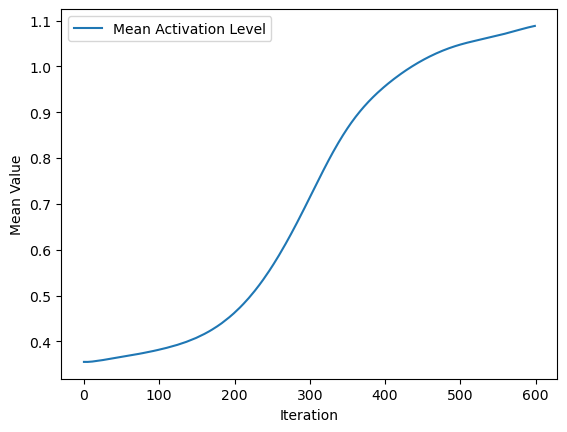

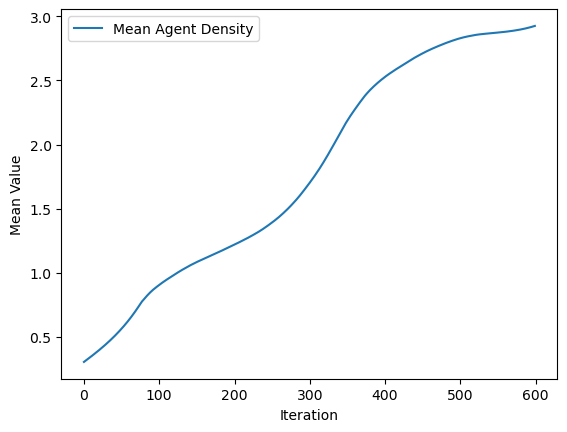

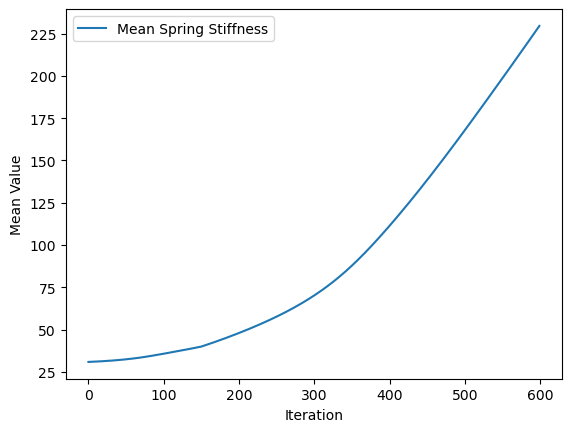

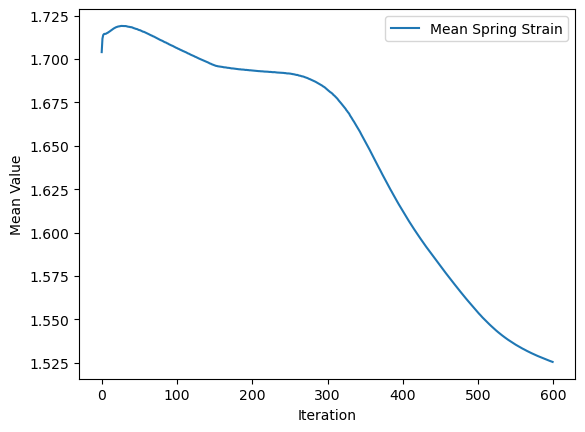

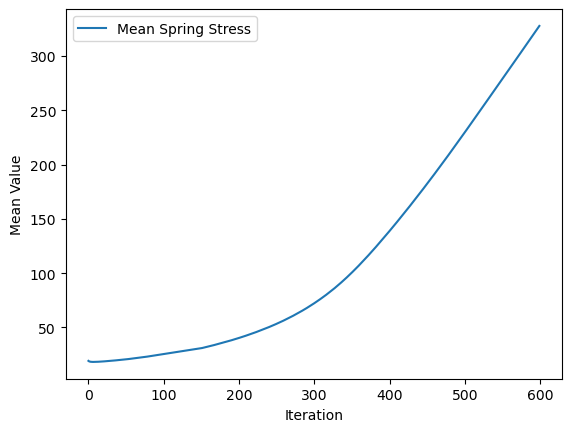

In [18]:
# Plotting the results after both phases
plt.figure()
plt.plot(activation_history, label='Mean Activation Level')
plt.xlabel('Iteration')
plt.ylabel('Mean Value')
plt.legend()
plt.show()

plt.figure()
plt.plot(agent_density_history, label='Mean Agent Density')
plt.xlabel('Iteration')
plt.ylabel('Mean Value')
plt.legend()
plt.show()

# Plotting the results after both phases
plt.figure()
plt.plot(stiffness_history, label='Mean Spring Stiffness')
plt.xlabel('Iteration')
plt.ylabel('Mean Value')
plt.legend()
plt.show()

# Plotting the results after both phases
plt.figure()
plt.plot(epsilon_history, label='Mean Spring Strain')
plt.xlabel('Iteration')
plt.ylabel('Mean Value')
plt.legend()
plt.show()

plt.figure()
plt.plot(stress_history, label='Mean Spring Stress')
plt.xlabel('Iteration')
plt.ylabel('Mean Value')
plt.legend()
plt.show()



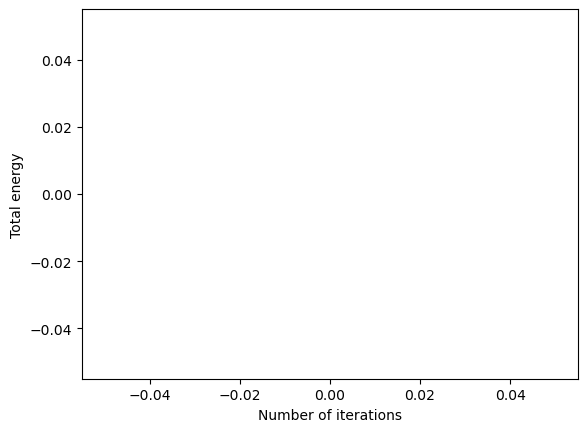

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

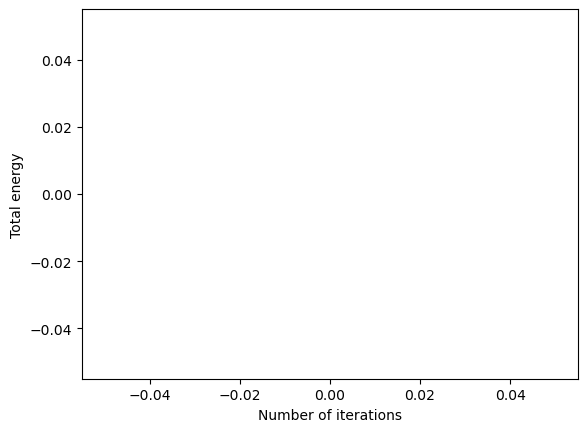

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Breathing cycle simulation completed.
Results from the last cycle step: {'cycle': 1, 'step': 2, 'strain': array([1.17391467, 1.17391203, 1.17391279, ..., 1.17391279, 1.17391203,
       1.17391279]), 'stress': array([22.04748307, 22.04656501, 22.04682907, ..., 22.04682907,
       22.04656501, 22.04682907])}


<Figure size 640x480 with 0 Axes>

In [19]:
# Initialize l0 for the resting length
l0_initial = 0.4 * (2 / np.sqrt(3) * dx / 2)
expansion_rate = 0.15                 # 15% expansion during inhalation
cycle_iterations = 0               # Iterations per cycle (inhalation or exhalation)
breathing_cycles = 1                  # Number of full breathing cycles
steps_per_cycle = 1                  # Steps within each inhalation/exhalation phase
output_folder = "simulation_results"   # Folder to store results

os.makedirs(output_folder, exist_ok=True)

# Simulate breathing cycle by modifying resting length
def simulate_breathing_cycle(points, edges, spring_constants, mu, T, tolerance, free_nodes, breathing_cycles=2, steps_per_cycle=10):
    cycle_data = []                    # Store strain and stress data
    current_points = points.copy()     # Start with the initial points and update after each step
    
    for cycle in range(breathing_cycles):
        # Inhalation phase: gradually increase resting length
        for step in range(steps_per_cycle):
            # Adjust l0 incrementally for inhalation
            l0_expanded = l0_initial * (1 + expansion_rate * (step / steps_per_cycle))

            # Run simulation with the current points
            final_positions, final_edges, final_spring_constants = simulate(
                current_points, edges, l0_expanded, spring_constants, mu, T, tolerance, cycle_iterations, free_nodes, plot_bar=False, print_results=False
            )

            # Calculate strain and stress for visualization
            strain, stress = compute_strain_and_stress(final_positions, edges, l0_expanded, final_spring_constants)

            # Scale points for visualization
            visualization_scale = 1 + expansion_rate * (step / steps_per_cycle)
            scaled_points = final_positions * visualization_scale

            # Export the scaled mesh for visualization
            filename = os.path.join(output_folder, f"hexagonal_mesh_cycle_{cycle+1}_step_{step+1}.vtk")
            meshio.write(
                filename,
                meshio.Mesh(
                    scaled_points,
                    cells=[("line", final_edges)],
                    cell_data={
                        "Stiffness": [final_spring_constants],
                        "Strain": [strain],
                        "Stress": [stress]
                    }
                )
            )
            cycle_data.append({"cycle": cycle + 1, "step": step + 1, "strain": strain, "stress": stress})

            # Update current_points for the next step
            current_points = final_positions

        # Exhalation phase: gradually return resting length to initial
        for step in range(steps_per_cycle):
            # Adjust l0 for exhalation
            l0_contracted = l0_initial * (1 + expansion_rate * (1 - step / steps_per_cycle))

            # Run simulation with the updated current_points
            final_positions, final_edges, final_spring_constants = simulate(
                current_points, edges, l0_contracted, spring_constants, mu, T, tolerance, cycle_iterations, free_nodes, plot_bar=False, print_results=False
            )

            # Calculate strain and stress for visualization
            strain, stress = compute_strain_and_stress(final_positions, edges, l0_contracted, final_spring_constants)

            # Scale points for visualization
            visualization_scale = 1 + expansion_rate * (1 - step / steps_per_cycle)
            scaled_points = final_positions * visualization_scale

            # Export the scaled mesh for visualization
            filename = os.path.join(output_folder, f"hexagonal_mesh_cycle_{cycle+1}_step_{step+1 + steps_per_cycle}.vtk")
            meshio.write(
                filename,
                meshio.Mesh(
                    scaled_points,
                    cells=[("line", final_edges)],
                    cell_data={
                        "Stiffness": [final_spring_constants],
                        "Strain": [strain],
                        "Stress": [stress]
                    }
                )
            )
            cycle_data.append({"cycle": cycle + 1, "step": step + 1 + steps_per_cycle, "strain": strain, "stress": stress})

            # Update current_points for the next step
            current_points = final_positions

    return cycle_data

# Run the breathing cycle simulation
cycle_data = simulate_breathing_cycle(
    points=points,
    edges=edges,
    spring_constants=spring_constants,
    mu=mu,
    T=T,
    tolerance=tolerance,
    free_nodes=np.where(boundary_id == 0)[0],
    breathing_cycles=breathing_cycles,
    steps_per_cycle=steps_per_cycle
)

print("Breathing cycle simulation completed.")
print("Results from the last cycle step:", cycle_data[-1])